# Protein Structure Modeling with Deep Learning (Tensorflow-Keras)

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Pre-processing Data (Creating Contact Maps)
    3) Designing the Neural Network
    4) Training and Prediction
    
*Note: Dataset Copyright (c) 2018 AlQuraishi Laboratory*

<hr>
<hr>
<hr>

In [1]:
'''first importing libraries'''

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Conv2DTranspose, Lambda
from tensorflow.python.keras import Sequential

import tensorflow.keras.backend as K

import tensorflow as tf

### 1) Reading and Exploring Data

First, let's read __*amino_acid_sequences*__ and __*C_alpha_atom_locations*__ data (including training and test datasets).

In [2]:
'''Loading datasets'''

x_read = np.load('./data/amino_acid_sequences.npz')
y_read = np.load('./data/C_alpha_atom_locations.npz')

x_train = x_read['x_train']
x_test = x_read['x_test']
y_train = y_read['y_train']
y_test = y_read['y_test']

print(x_train.shape) # shape corresponding to: [Proteins, Amino Acids]
print(x_test.shape) # shape corresponding to: [Proteins, Amino Acids]
print(y_train.shape) # shape corresponding to: [Proteins, Amino Acids, x/y/y of C_alpha atoms]
print(y_test.shape) # shape corresponding to: [Proteins, Amino Acids, x/y/y of C_alpha atoms]

(3700, 128)
(1825, 128)
(3700, 128, 3)
(1825, 128, 3)


This dataset is selected form CASP11 dataset of [ProteinNet](https://github.com/aqlaboratory/proteinnet) project. I have selected a random set of proteins which have length between 64 and 128 amino acids for this project. Original dataset was in text and TF record format, I have converted to __*npz*__ before to make the codes simple here.

There are 5,525 proteins in this dataset (3,703 are in the training dataset + 1,822 are in the test dataset). While minimum length of a protein chains is 64, maximum length of a protein chains is 128. Input data (__*x_read*__) contains sequence of amino acids. Amino acids are encoded with integers as below (there are 20 amino acid types and denoted by following letters and corresponding integer is in the __*x_read*__ data).

*'A':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, 'P':13, 'Q':14, 'R':15, 'S':16, 'T':17, 'V':18, 'W':19, 'Y':20*

Output data (__*y_read*__) contains 3D Cartesian coordinates (x, y and z location) of C_Alpha atoms of each amino acids. 

Note: Each amino acid contains several atoms. And there are 3 major atoms in each amino acid which are responsible for the overall structure. These atoms are knows as protein backbone atoms. And they are known as __*N*__, __*C_alpha*__, and __*C_beta*__ atoms. In this case, I have only considered __*C_Alpha*__ atom of each amino acid to represent 3D structures of proteins.

### 2) Pre-processing Data (Creating Contact Maps)

Even I have 3D Cartesian coordinates (x, y and z location) of __*C_Alpha*__ atoms representing protein structures, proteins can be in different orientations and locations. Even though same protein in different orientations or locations has same shape and also same chemical properties. So I have to figure out representation for protein structures which are rotational and translational invariant. This representation is known as proteins contact maps.

Contact maps can be defined in various ways. But in this case, I have defined contact maps by relative distance between pair of each __*C_Alpha*__ atoms of each amino acids. And I have used 9 angstrom distance threshold (900 threshold value) to create binary contact maps. Details about Contact maps can be read in this nice [Wikipedia Article](https://en.wikipedia.org/wiki/Protein_contact_map).

Protein contact maps are calculated for training and test datasets as below. Since, distances are calculated for each pair of __*C_Alpha*__ atoms of each amino acids, this process will take some time to complete.

In [3]:
'''creating contact maps for training dataset'''

## first defined numpy matrixes to store contact maps.
cmap_train = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[1], 1))

for i1 in range(y_train.shape[0]):    
    for i2 in range(y_train.shape[1]):
        
        # if amino acid sequence ends, loop continues saving computing time.
        if x_train[i1, i2] == 0:
            continue
        
        for i3 in range(y_train.shape[1]):
            
            # if amino acid sequence ends, loop continues saving computing time.
            if x_train[i1, i3] == 0:
                continue
            
            # distance calculation and thresholding
            d_sqr = (y_train[i1,i2,0]-y_train[i1,i3,0])**2 + (y_train[i1,i2,1]-y_train[i1,i3,1])**2 + (y_train[i1,i2,2]-y_train[i1,i3,2])**2
            cmap_train[i1, i2, i3, 0] = (d_sqr**0.5) > 900 # 9 angstrom distance threshold (900 threshold value)

In [4]:
'''creating contact maps for test dataset'''

## first defined numpy matrixes to store contact maps.
cmap_test = np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[1], 1))

for i1 in range(y_test.shape[0]):
    for i2 in range(y_test.shape[1]):
        
        # if amino acid sequence ends, loop continues saving computing time.
        if x_test[i1, i2] == 0:
            continue
        
        for i3 in range(y_test.shape[1]):
            
            # if amino acid sequence ends, loop continues saving computing time.
            if x_test[i1, i3] == 0:
                continue
            
            # distance calculation and thresholding
            d_sqr = (y_test[i1,i2,0]-y_test[i1,i3,0])**2 + (y_test[i1,i2,1]-y_test[i1,i3,1])**2 + (y_test[i1,i2,2]-y_test[i1,i3,2])**2
            cmap_test[i1, i2, i3, 0] = (d_sqr**0.5) > 900 # 9 angstrom distance threshold (900 threshold value)

Let's plot random contact map from the test dataset to see how it looks.

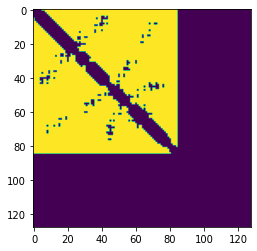

In [5]:
rand_idx = np.random.randint(0,cmap_test.shape[0]) # generation random index to choose random protein

plt.imshow(cmap_test[rand_idx,:,:,0])
plt.show()

### 3) Designing the Neural Network

Now we can see that, sequence data of __*C_Alpha*__ atoms area converted to 2D data (contact maps) for each protein. So now input will be a sequence of amino acids (1D data) and output will be contact maps (2D data). So neural network design should capture this transformation within the network.

Let's go ahead and design a neural network for the protein structure prediction now.

In [6]:
model = Sequential()

'''Section 1: input data embedding'''

model.add( Embedding(21, 3, mask_zero=True, input_length=128) ) # embedding vector length is 3

'''Section 2: encoder (first part of the network) with 1D operations'''

model.add( Conv1D(64, 3, activation='relu', padding='same') )
model.add( Dropout(0.25) )
model.add( Conv1D(64, 3, activation='relu', padding='same') )
model.add( MaxPooling1D(2) )
model.add( Conv1D(64, 3, activation='relu', padding='same') )
model.add( Dropout(0.25) )
model.add( Conv1D(64, 3, activation='relu', padding='same') )
model.add( MaxPooling1D(2) )
model.add( Conv1D(128, 3, activation='relu', padding='same') )
model.add( Dropout(0.25) )
model.add( Conv1D(128, 3, activation='relu', padding='same') )
model.add( MaxPooling1D(2) )
model.add( Conv1D(128, 3, activation='relu', padding='same') )
model.add( Dropout(0.25) )
model.add( Conv1D(128, 3, activation='relu', padding='same') )

model.add( Conv1D(32, 1, activation='relu', padding='same') )
model.add( Conv1D(4, 1, activation='relu', padding='same') )

'''Section 3: middle part of the network, converting 1D data to 2D data'''

def from1Dto2D(arg_in):
    b_size = tf.shape(arg_in)[0] # getting batch size
    
    ## matrix multiplications are performed separately for each band.
    # for band 0
    b0_1 = tf.linalg.matmul(arg_in[:,:,0:1], tf.ones((b_size,1,16)))
    b0_2 = tf.linalg.matmul(tf.ones((b_size,16,1)), arg_in[:,:,0:1], transpose_b=True)
    # for band 1
    b1_1 = tf.linalg.matmul(arg_in[:,:,1:2], tf.ones((b_size,1,16)))
    b1_2 = tf.linalg.matmul(tf.ones((b_size,16,1)), arg_in[:,:,1:2], transpose_b=True)
    # for band 2
    b2_1 = tf.linalg.matmul(arg_in[:,:,2:3], tf.ones((b_size,1,16)))
    b2_2 = tf.linalg.matmul(tf.ones((b_size,16,1)), arg_in[:,:,2:3], transpose_b=True)
    # for band 3
    b3_1 = tf.linalg.matmul(arg_in[:,:,3:4], tf.ones((b_size,1,16)))
    b3_2 = tf.linalg.matmul(tf.ones((b_size,16,1)), arg_in[:,:,3:4], transpose_b=True)   
    
    return tf.stack((b0_1, b1_1, b2_1, b3_1, b0_2, b1_2, b2_2, b3_2), axis=-1)
    

model.add( Lambda(from1Dto2D) )

'''Section 4: decoder (last part of the network) with 2D operations '''

model.add( Conv2DTranspose(64, (1, 1), activation='relu', padding='same') )
model.add( Conv2DTranspose(64, (1, 1), activation='relu', padding='same') )

model.add( Conv2DTranspose(128, (3, 3), activation='relu',  padding='same') )
model.add( Dropout(0.5) )
model.add( Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu',  padding='same') )
model.add( Conv2DTranspose(128, (3, 3), activation='relu',  padding='same') )
model.add( Dropout(0.5) )
model.add( Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu',  padding='same') )
model.add( Conv2DTranspose(64, (3, 3), activation='relu',  padding='same') )
model.add( Dropout(0.5) )
model.add( Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same') )
model.add( Conv2DTranspose(64, (3, 3), activation='relu',  padding='same') )
model.add( Dropout(0.5) )
model.add( Conv2DTranspose(64, (3, 3), activation='relu',  padding='same') )

model.add( Conv2DTranspose(64, (1, 1), activation='relu', padding='same') )
model.add( Conv2DTranspose(64, (1, 1), activation='relu', padding='same') )
model.add( Conv2DTranspose(1, (1, 1), activation='relu', padding='same') ) # single unit because of single band output

model.compile(loss='mean_squared_error', optimizer='adam') # setting loss and optimizer

model.summary() # printing the model summary

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 3)            63        
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 64)           640       
_________________________________________________________________
dropout (Dropout)            (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_______________________________________________________

__Explanations for each sections of the model is as follows:__

__*Section 1:*__ At the begining, I have used embedding layer converting encoded integers (each amino acid is represented by an integer value) input to a continuous vector. As an example, amino acid *'A'* is represented by value 1, and amino acid *'C'* is represented by value 2. This doesn’t mean, *(amino acid 'C') = 2 x (amino acis 'A')*. These values are independent. One way to get rid of these dependencies are use of one-hot encoding. But here, I have used another technique call __*Embedding*__. Embedding converts encoded integers to continuous vectors. Nice reference about embedding can be accessed by this link [how-does-keras-embedding-layer-work](https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work).

__*Section 2:*__ After the embedding process, I have an encoding section of the neural network with 1D convolutions, 1D max pooling operations and dropout layers which are typical layers in many 1D neural network architectures. Since our input are in 1D, all operations are in 1D within the encoder.

__*Section 3:*__ Since contacts maps are in 2D, we have to convert 1D output of the encoder to 2D. If we look in to the process of contact map creation in detail, we can see that, 2D contact maps are produced by associating all amino acid pairs within a protein. This association can be achieved from 1D output of the encoder within neural network architecture too. This operation is summarized with following mathematical formula.

    Stack( A x I , I x Transpose(A) )

Where:

    - A: 1D output vector of Encoder
    - I: Identity matrix

This figure shows this operation in more detail,

    - Let's assume 1D output of the encoder is [V1, V2, V3] vector

<img src="./graphics/Conv1Dto2D.PNG" alt="Convert 1D to 2D" width="80%">

Similar idea can be seen in following figure from a another study too.

<img src="./graphics/journal.pcbi.1005324.g001.PNG" alt="Convert 1D to 2D - Reference" width="60%">

<sup>__Source__ - *Wang S, Sun S, Li Z, Zhang R, Xu J. Accurate De Novo Prediction of Protein Contact Map by Ultra-Deep Learning Model. PLoS Comput Biol. 2017;13(1):e1005324. Published 2017 Jan 5. doi:10.1371/journal.pcbi.1005324*</sup>

__*Section 4:*__ With this conversion from 1D to 2D, decoder includes 2D convolutions, 2D max pooling operations and dropout layers as usual with 2D data.

Finally, I have used __*Mean Square Error (MSE)*__ as the loss function. And __*Adam*__ optimizer as the optimizing algorithm.

### 3) Training and Prediction

In [7]:
'''training the model'''

fit_h = model.fit(x_train, cmap_train, batch_size=100, epochs=500, verbose=0, shuffle=1, validation_data=(x_test,cmap_test))

*Note: set verbose=1 to see training progress for each epoch. Single epoch takes 13s in single NVIDIA GTX 1080 Ti GPU.*

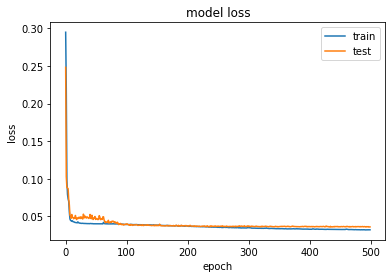

In [24]:
'''plotting loss curves'''

plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
'''prediction over the test dataset from the trained model '''

pred_test = model.predict(x_test, batch_size=100)

pred_test = pred_test > 0.9 # applying empirical threshold to extract binary contact maps

print(pred_test.shape)

(1825, 128, 128, 1)


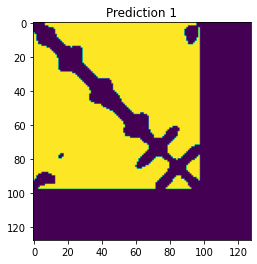

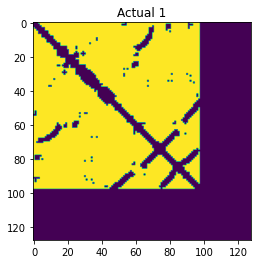

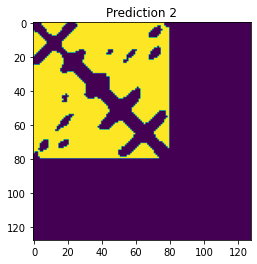

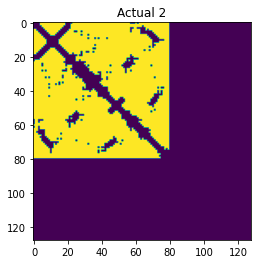

In [22]:
'''plot couple of predicted contact maps vs actual contact maps to see model prediction'''

rand_idx = np.random.randint(0,cmap_test.shape[0]) # generation random index to choose random protein

plt.imshow(pred_test[rand_idx,:,:,0])
plt.title('Prediction 1')
plt.show()
plt.imshow(cmap_test[rand_idx,:,:,0])
plt.title('Actual 1')
plt.show()

rand_idx = np.random.randint(0,cmap_test.shape[0]) # generation random index to choose random protein

plt.imshow(pred_test[rand_idx,:,:,0])
plt.title('Prediction 2')
plt.show()
plt.imshow(cmap_test[rand_idx,:,:,0])
plt.title('Actual 2')
plt.show()